군집화를 위한 데이터를 생성하여 이를 outlier detection 에 이용해 봅니다. `make_circular_clusters()` 함수는 군집과 노이즈를 적절히 섞어서 생성해줍니다. 군집은 원형으로 생성되며, 원형 내 각 지역은 동일한 밀도로 생성됩니다. 노이즈는 모든 영역에 임의로 생성됩니다. 그렇기 때문에 군집 내에도 노이즈가 발생할 수 있습니다. 군집에 속한 데이터는 labels 이 0 보다 크며, 노이즈는 -1 입니다.

In [1]:
import numpy as np
from bokeh.plotting import show
from soydata.data.clustering import make_circular_clusters
from soydata.visualize import scatterplot
from soydata.visualize import use_notebook

use_notebook()

X, labels = make_circular_clusters(n_clusters=10, r_min=0.05, r_max=0.15,
    equal_density=True, noise=0.05, seed=0, size_min=150, size_max=250)

data_indices = np.where(labels >= 0)[0]
noise_indices = np.where(labels == -1)[0]

p_data = scatterplot(X[data_indices], color='lightgrey', size=3, title='Data and noise', show_inline=False)
p_data = scatterplot(X[noise_indices], color='#2b83ba', p=p_data)

Loading BokehJS ...

Isolation forest 를 이용하여 `fit_predict` 를 실행하면 true noise 외에도 군집의 가장자리의 점들이 모두 noise 로 판별됩니다. 이는 outlier score 의 threshold 가 자동으로 설정되기 때문입니다.

In [2]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, bootstrap=False, random_state=0, verbose=1)
predicted = isolation_forest.fit_predict(X)

predicted_data_indices = np.where(predicted >= 0)[0]
predicted_noise_indices = np.where(predicted == -1)[0]

p = scatterplot(X[predicted_data_indices], color='lightgrey',
    size=3, title='Outlier detection', show_inline=False)
p = scatterplot(X[predicted_noise_indices], color='#2b83ba', p=p)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


학습된 isolation forest 를 이용하여 normal data score 를 계산해봅니다. 이는 `decision_function()` 을 이용하면 계산할 수 있습니다. 그리고 그 값의 분포를 `seaborn.distplot()` 을 이용하여 살펴봅니다. 이러한 점수표를 바탕으로 적절한 outlier score threshold 를 설정해봅니다.

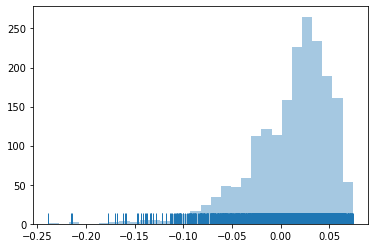

In [3]:
%matplotlib inline
import seaborn as sns

anomaly_score = isolation_forest.decision_function(X)
sns.distplot(anomaly_score, bins=30, kde=False, rug=True)

위의 distribution plot 을 기반으로 몇 가지 thresholds 에 대해 outlier prediction 의 경향이 어떻게 변하는지 살펴봅니다. 이처럼 distribution plot 과 시각적 혹은 test dataset 을 기반으로 성능을 측정하며 적절한 threshold 를 설정해야 합니다.

In [4]:
from bokeh.layouts import gridplot


figures = []
for threshold in [-0.2, -0.15, -0.1, -0.07, -0.05]:

    custom_data_indices = np.where(anomaly_score >= threshold)[0]
    custom_noise_indices = np.where(anomaly_score < threshold)[0]

    title = f'Isolation Forest (threshold={threshold})'
    p = scatterplot(X[custom_data_indices], color='lightgrey',
        size=3, title=title, width=400, height=400, show_inline=False)
    p = scatterplot(X[custom_noise_indices], color='#2b83ba', p=p, show_inline=False)
    figures.append(p)


p_data.width = 400
p_data.height = 400
figures.insert(0, p_data)

grid = [figures[:3], figures[3:]]
gp_custom_if = gridplot(grid)
show(gp_custom_if)